<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

# Model Selection for Causal Effect Model with the RScorer

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import econml

In [3]:
## Ignore warnings
import warnings
warnings.filterwarnings('ignore') 

In [4]:
# Main imports
from econml.dml import DML, LinearDML, SparseLinearDML, NonParamDML
from econml.metalearners import XLearner, TLearner, SLearner, DomainAdaptationLearner
from econml.drlearner import DRLearner

import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

## 2. Example Usage with Single Binary Treatment Synthetic Data

### 2.1. DGP 
We use the following DGP:

\begin{align}
T \sim & \text{Bernoulli}\left(f(W)\right), &\; f(W)=\sigma(\langle W, \beta\rangle + \eta), \;\eta \sim \text{Uniform}(-1, 1)\\
Y = & T\cdot \theta(X) + \langle W, \gamma\rangle + \epsilon, & \; \epsilon \sim \text{Uniform}(-1, 1)\\
W \sim & \text{Normal}(0,\, I_{n_w}) & \\
X \sim & \text{Uniform}(0,\, 1)^{n_x}
\end{align}

where $W$ is a matrix of high-dimensional confounders, $\beta, \gamma$ have high sparsity and $\sigma$ is the sigmoid function.

For this DGP, 
\begin{align}
\theta(x) = 1\{x_0 > .5\}
\end{align}

In [5]:
# Treatment effect function
def exp_te(x):
    return x[:, 0] > 0.5

np.random.seed(123)
n = 5000
support_size = 5
n_x = 10
# Outcome support
support_Y = np.random.choice(range(n_x), size=support_size, replace=False)
coefs_Y = np.random.uniform(0, 1, size=support_size)
epsilon_sample = lambda n:np.random.uniform(-1, 1, size=n)
# Treatment support
support_T = support_Y
coefs_T = np.random.uniform(0, 1, size=support_size)
eta_sample = lambda n: np.random.uniform(-1, 1, size=n) 

# Generate controls, covariates, treatments and outcomes
X = np.random.uniform(0, 1, size=(n, n_x))
# Heterogeneous treatment effects
TE = exp_te(X)
# Define treatment
log_odds = np.dot(X[:, support_T], coefs_T) + eta_sample(n)
T_sigmoid = 1/(1 + np.exp(-log_odds))
T = np.array([np.random.binomial(1, p) for p in T_sigmoid])
# Define the outcome
Y = TE * T + np.dot(X[:, support_Y], coefs_Y) + epsilon_sample(n)

# get testing data
X_test = np.random.uniform(0, 1, size=(n, n_x))
X_test[:, 0] = np.linspace(0, 1, n)
expected_te_test = exp_te(X_test)

### 2.2. Train Estimator

In [6]:
reg = lambda: RandomForestRegressor(min_samples_leaf=10)
clf = lambda: RandomForestClassifier(min_samples_leaf=10)

In [7]:
X_train, X_val, T_train, T_val, Y_train, Y_val = train_test_split(X, T, Y, test_size=.4)

In [8]:
models = [('ldml', LinearDML(model_y=reg(), model_t=clf(), discrete_treatment=True,
                             linear_first_stages=False, n_splits=3)),
          ('sldml', SparseLinearDML(model_y=reg(), model_t=clf(), discrete_treatment=True,
                                    featurizer=PolynomialFeatures(degree=2, include_bias=False),
                                    linear_first_stages=False, n_splits=3)),
          ('xlearner', XLearner(models=reg(), cate_models=reg(), propensity_model=clf())),
          ('dalearner', DomainAdaptationLearner(models=reg(), final_models=reg(), propensity_model=clf())),
          ('slearner', SLearner(overall_model=reg())),
          ('tlearner', TLearner(models=reg())),
          ('drlearner', DRLearner(model_propensity=clf(), model_regression=reg(),
                                  model_final=reg(), n_splits=3)),
          ('rlearner', NonParamDML(model_y=reg(), model_t=clf(), model_final=reg(),
                                   discrete_treatment=True, n_splits=3)),
          ('dml3dlasso', DML(model_y=reg(), model_t=clf(), model_final=LassoCV(), discrete_treatment=True,
                             featurizer=PolynomialFeatures(degree=3),
                             linear_first_stages=False, n_splits=3))
]

In [9]:
from joblib import Parallel, delayed

def fit_model(name, model):
    return name, model.fit(Y_train, T_train, X=X_train)

models = Parallel(n_jobs=-1, verbose=1)(delayed(fit_model)(name, mdl) for name, mdl in models)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of   9 | elapsed:   23.0s remaining:   28.7s
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   37.4s finished


In [10]:
from econml.score import RScorer

scorer = RScorer(model_y=reg(), model_t=clf(),
                 discrete_treatment=True, n_splits=3,
                 mc_iters=3, mc_agg='median')
scorer.fit(Y_val, T_val, X=X_val)

In [11]:
rscore = [scorer.score(mdl) for _, mdl in models]

In [12]:
expected_te_val = exp_te(X_val)

In [13]:
rootpehe = [np.sqrt(np.mean((expected_te_val.flatten() - mdl.effect(X_val).flatten())**2)) for _, mdl in models]

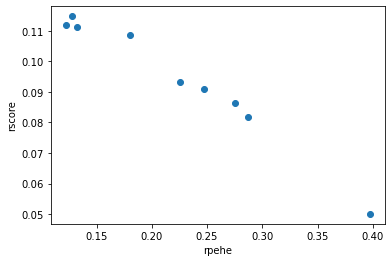

In [14]:
plt.scatter(rootpehe, rscore)
plt.xlabel('rpehe')
plt.ylabel('rscore')
plt.show()

### 2.3. Performance Visualization

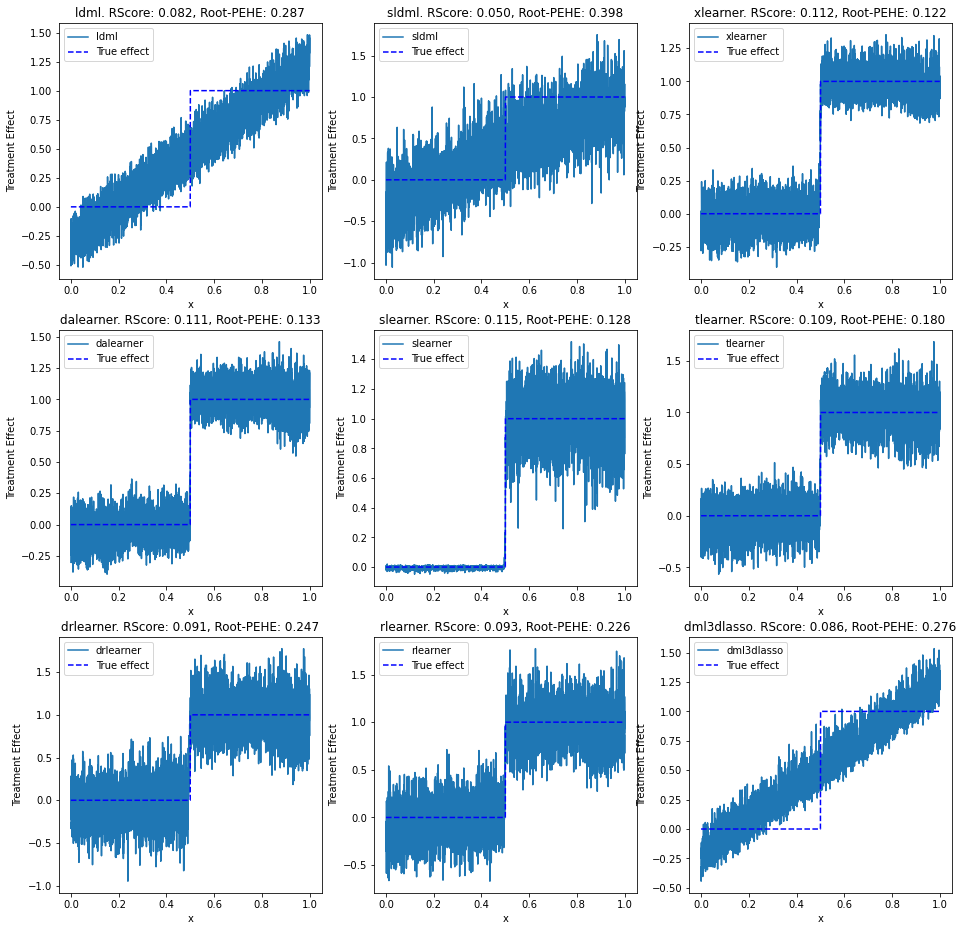

In [15]:
plt.figure(figsize=(16, 16))
rows = int(np.ceil(len(models) / 3))
for it, (name, mdl) in enumerate(models):
    plt.subplot(rows, 3, it + 1)
    plt.title('{}. RScore: {:.3f}, Root-PEHE: {:.3f}'.format(name, rscore[it], rootpehe[it]))
    plt.plot(X_test[:, 0], mdl.effect(X_test), label='{}'.format(name))
    plt.plot(X_test[:, 0], expected_te_test, 'b--', label='True effect')
    plt.ylabel('Treatment Effect')
    plt.xlabel('x')
    plt.legend()
plt.show()

# Getting the Best Model

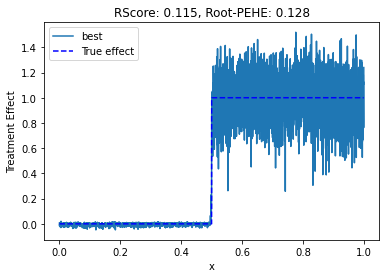

In [16]:
mdl, score  = scorer.best_model([mdl for _, mdl in models])
rootpehe_best = np.sqrt(np.mean((expected_te_val.flatten() - mdl.effect(X_val).flatten())**2))
plt.figure()
plt.title('RScore: {:.3f}, Root-PEHE: {:.3f}'.format(score, rootpehe_best))
plt.plot(X_test[:, 0], mdl.effect(X_test), label='best')
plt.plot(X_test[:, 0], expected_te_test, 'b--', label='True effect')
plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.legend()
plt.show()

# Getting an Ensemble based on Scores

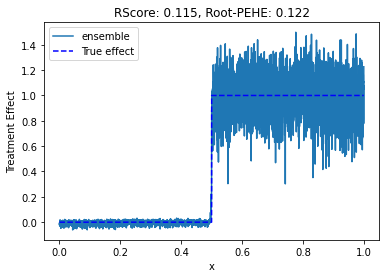

In [17]:
mdl, score  = scorer.ensemble([mdl for _, mdl in models])
rootpehe_ensemble = np.sqrt(np.mean((expected_te_val.flatten() - mdl.effect(X_val).flatten())**2))
plt.figure()
plt.title('RScore: {:.3f}, Root-PEHE: {:.3f}'.format(score, rootpehe_ensemble))
plt.plot(X_test[:, 0], mdl.effect(X_test), label='ensemble')
plt.plot(X_test[:, 0], expected_te_test, 'b--', label='True effect')
plt.ylabel('Treatment Effect')
plt.xlabel('x')
plt.legend()
plt.show()

# Semi-Synthetic Data

In [18]:
reg = lambda: RandomForestRegressor(min_samples_leaf=10, random_state=123)
clf = lambda: RandomForestClassifier(min_samples_leaf=10, random_state=123)

In [19]:
from econml.data.dgps import ihdp_surface_B, ihdp_surface_A
Y, T, X, expected_te = ihdp_surface_B(random_state=123)

In [20]:
X_train, X_val, T_train, T_val,\
Y_train, Y_val, expected_te_train, expected_te_val = train_test_split(X, T, Y, expected_te, test_size=.3, random_state=123)

In [21]:
models = [('ldml', LinearDML(model_y=reg(), model_t=clf(), discrete_treatment=True,
                             linear_first_stages=False, n_splits=3)),
          ('xlearner', XLearner(models=reg(), cate_models=reg(), propensity_model=clf())),
          ('dalearner', DomainAdaptationLearner(models=reg(), final_models=reg(), propensity_model=clf())),
          ('slearner', SLearner(overall_model=reg())),
          ('tlearner', TLearner(models=reg())),
          ('drlearner', DRLearner(model_propensity=clf(), model_regression=reg(),
                                  model_final=reg(), n_splits=3)),
          ('rlearner', NonParamDML(model_y=reg(), model_t=clf(), model_final=reg(),
                                   discrete_treatment=True, n_splits=3)),
          ('dml3dlasso', DML(model_y=reg(), model_t=clf(), model_final=LassoCV(), discrete_treatment=True,
                             featurizer=PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
                             linear_first_stages=False, n_splits=3))
]

In [22]:
from joblib import Parallel, delayed

def fit_model(name, model):
    print("Training: ", name)
    model.fit(Y_train, T_train, X=X_train)
    print("Done training: ", name)
    return name, model

models = Parallel(n_jobs=-1, verbose=1)(delayed(fit_model)(name, mdl) for name, mdl in models)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:    0.6s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    5.9s finished


In [23]:
from econml.score import RScorer

scorer = RScorer(model_y=reg(), model_t=clf(),
                 discrete_treatment=True, n_splits=3,
                 mc_iters=3, mc_agg='median')
scorer.fit(Y_val, T_val, X=X_val)

In [24]:
rscore = [scorer.score(mdl) for _, mdl in models]

In [25]:
rootpehe = [np.sqrt(np.mean((expected_te.flatten() - mdl.effect(X).flatten())**2)) for _, mdl in models]

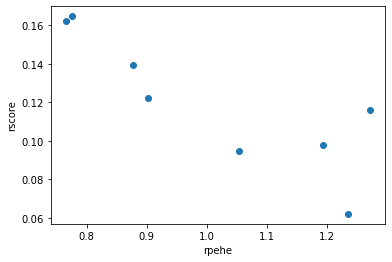

In [26]:
plt.scatter(rootpehe, rscore)
plt.xlabel('rpehe')
plt.ylabel('rscore')
plt.show()

In [27]:
best, score  = scorer.best_model([mdl for _, mdl in models])
rootpehe_best = np.sqrt(np.nanmean((expected_te_val.flatten() - best.effect(X_val).flatten())**2))
rootpehe_best

0.7393917952588073

In [28]:
ensemble, score  = scorer.ensemble([mdl for _, mdl in models])
rootpehe_ensemble = np.sqrt(np.nanmean((expected_te_val.flatten() - ensemble.effect(X_val).flatten())**2))
rootpehe_ensemble

0.7346069084804471

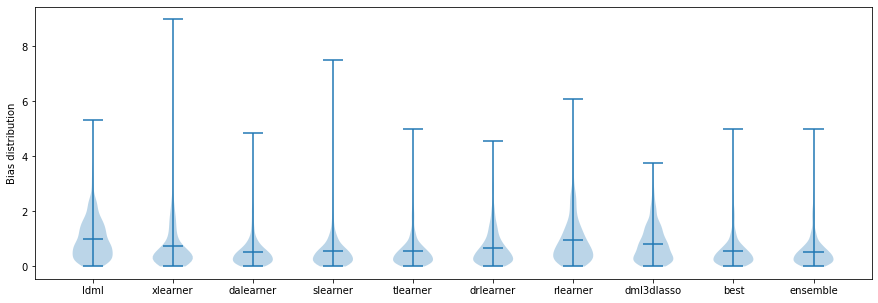

In [29]:
# Visualization of bias distribution
plt.figure(figsize=(15, 5))
plt.violinplot([np.abs(mdl.effect(X).flatten() - expected_te) for _, mdl in models] + 
               [np.abs(best.effect(X).flatten() - expected_te)] +
               [np.abs(ensemble.effect(X).flatten() - expected_te)], showmeans=True)
plt.ylabel("Bias distribution")
plt.xticks(np.arange(1, len(models) + 3), [name for name, _ in models] + ['best', 'ensemble'])
plt.show()